# Κατασκευή Νευρωνικού Δικτύου

***

### Εισαγωγή δεδομένων

Για αρχή θα πειραματιστούμε με τα data από το simulation και πολύ απλοϊκά μοντέλα με λίγες παραμέτρους.

Παίρνουμε τα data και δημιουργούμε τα labels που πρέπει τελικά να εντοπιστούν στην μορφή $[x_l, y_l]$

In [1]:
import torch
import sklearn
import pandas as pd
import numpy as np
#import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
Data = pd.read_pickle("Sim_Data_Noisy.pkl")

rfid_label = (Data['x_tag'], Data['y_tag'])
rfid_label = np.array(rfid_label).T
print(rfid_label.shape)

(1000, 2)


Από την στιγμή που η διαδικασία παραγωγής δεδομένων παράγει διαφορετικού μήκους διανύσματα, δεν μπορούμε να δημιουργήσουμε ένα tensor διάστασης $(1000,1000,4)$, αντιθέτως ορίζουμε πρώτα την συνάρτηση με την οποία λαμβάνουμε segments και έπειτα μετατρέπουμε τα δεδομένα μας σε ίσου μήκους διανύσματα με την βοήθεια της συνάρτησης ```sample_random_segments```

***

### Data Augmentation μέσω segmentation

Ορίζουμε την συνάρτηση παρακάτω μέσω της οποίας μετασχηματίζουμε κάθε μία μέτρηση σε ένα πλήθος x που μπορούμε να διαλέξουμε εμείς με y αριθμό μετρήσεων στο κάθε ένα. Αυτό συμβαίνει καθώς για κάθε ένα tag σπάμε τις μετρήσεις σε x (όχι απαραίτητα μη επικαλυπτόμενες) μετρήσεις μεγέθους y.

**UPDATE** Επιπλέον μέσα από αυτή την συνάρτηση μετατοπίζουμε και την x συντεταγμένη τόσο του tag όσο και του segment στο 0

In [3]:
#Take random segments of the full array
def sample_random_segments(tensor1, rfid, segment_length, num_samples):
    if len(tensor1) < segment_length:
        raise ValueError("Segment length must be smaller than or equal to array length.")
    
    max_start_index = len(tensor1) - segment_length  # Ensure segment stays within bounds
    start_indices = np.random.randint(0, max_start_index + 1, size=num_samples)

    segments = np.empty((num_samples, segment_length, tensor1.shape[1]))
    rfid_arr = np.empty((num_samples,rfid.shape[0]))

    for idx, start in enumerate(start_indices):
        segments[idx] = tensor1[start:start+segment_length] # We create the segments as before 
        rfid_arr[idx] = np.array((rfid[0] - segments[idx,0,0], rfid[1])) # We subtract from the rfid X coordinate the starting X value of the segment.
        segments[idx,:,0] -= segments[idx,0,0] # We repeat this process for the X coordinate of the segment.
    # We now have 2 arrays to return, one is of shape [num_of_samples, segment_length, 4] and it represents the segments as before, BUT all brought back to 0 for their X coordinate
    # The second array represents the new rfid label since is has been moved from the standard X=2 coordinate to the new x' = X - X_start_segment
    
    return segments, rfid_arr

Όπως περιγράφω και στα σχόλια η παραπάνω συνάρτηση εξυπηρετεί δύο σκοπούς. 
- Δημιουργεί ίσου μήκους διανύσματα, καθώς αυτά που είχαμε πριν ήταν διαφορετικού
- Μεταφέρει τα segments στο 0 και μετακινεί και τα labels σε αντίστοιχη θέση αναφορικά με τα segments.

In [4]:
num_of_samples = 5 # Number of samples per tag
segment_length = 200 # Length of each segment

info_tensor = np.empty((0, segment_length, 4))
labels = np.empty((0,rfid_label.shape[1]))

for i in range(len(rfid_label)):
    Data.loc[i, 'Phases'] = Data.loc[i, 'Phases'].reshape(-1, 1)
    result = np.concatenate((Data.loc[i, 'robot_pos'], Data.loc[i, 'Phases'].reshape(-1, 1)), axis=1)
    temp_info, temp_rfid = sample_random_segments(result, rfid_label[i], segment_length, num_of_samples) 
    info_tensor = np.concatenate((info_tensor, temp_info), axis=0)
    labels = np.concatenate((labels,temp_rfid), axis=0)


In [5]:
print(info_tensor.shape) 
print(labels.shape)

(5000, 200, 4)
(5000, 2)


Ας ελέγξουμε τις παραπάνω παρατηρήσεις

In [6]:
labels[:5], labels[5:10]

(array([[-1.22596505,  0.1       ],
        [-1.15043209,  0.1       ],
        [-0.40515204,  0.1       ],
        [ 1.02830207,  0.1       ],
        [ 0.00346724,  0.1       ]]),
 array([[ 0.92390933,  0.1029029 ],
        [ 1.15985789,  0.1029029 ],
        [-0.96443656,  0.1029029 ],
        [ 1.06999494,  0.1029029 ],
        [ 0.76705715,  0.1029029 ]]))

Όπως βλέπουμε ανά 5 έχουν σταθερό y αλλά διαφορετικό X καθώς αυτό έχει μετατοπιστεί ανάλογα με την Χ συντεταγμένη του αντίστοιχου segment. Ας δούμε και μερικά segments.

In [7]:
info_tensor[:4,:3]

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.48312816e+01],
        [2.64499277e-03, 0.00000000e+00, 0.00000000e+00, 4.48828532e+01],
        [5.44861791e-03, 0.00000000e+00, 0.00000000e+00, 4.48941442e+01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.21437689e+01],
        [2.12048756e-03, 0.00000000e+00, 0.00000000e+00, 4.21278055e+01],
        [8.11489234e-03, 0.00000000e+00, 0.00000000e+00, 4.23406158e+01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.54382867e+01],
        [3.77234962e-03, 0.00000000e+00, 0.00000000e+00, 1.56832914e+01],
        [6.45156720e-03, 0.00000000e+00, 0.00000000e+00, 1.58378375e+01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.76447839e+01],
        [3.13976828e-03, 0.00000000e+00, 0.00000000e+00, 3.75941090e+01],
        [1.12504955e-02, 0.00000000e+00, 0.00000000e+00, 3.71662524e+01]]])

Επίσης παρατηρούμε ότι έχουν μετατοπιστεί στο μηδέν.

***

### Linear Interpolation για να έχουμε ίδιο μέγεθος σε όλα τα samples

Μιας και τα δεδομένα μας περιμένουμε να περιέχουν ασυνέχειες, σκεφτόμαστε ότι μέσω της γραμμικής παρεμβολής θα βεβαιωνόμαστε για το σταθερό μήκος του Input στο μοντέλο. Αυτό υλοποιείται παρακάτω.

In [8]:
def lin_interpolation(data, length):
    x = np.linspace(data[0,0],data[-1,0], length)
   
    # Create interpolation results
    result = np.empty((length, data.shape[1]))
    result = np.array([x, np.interp(x, data[:,0], data[:,1]), np.interp(x, data[:,0], data[:,2]), np.interp(x, data[:,0], data[:,3])]).T
    return result

Έχοντας πλέον την συνάρτηση που θα δημιουργήσει τα δεδομένα μετατρέπουμε τον πίνακα των samples στον τελικό πίνακα που θα μπει στο μοντέλο.

In [9]:
interp_length = 1000
input_array = np.empty((info_tensor.shape[0],interp_length, 4))

for i in range(len(info_tensor)):
    input_array[i] = lin_interpolation(info_tensor[i], interp_length)

input_array.shape

(5000, 1000, 4)

***

### Προβλέψεις μέσω XGB

Τo XGB δεν υποστηρίζει πολυδιάστατη είσοδο όπως θα θέλαμε καθώς υπάρχει χρονική συσχέτιση μεταξύ των δεδομένων. Επίσης δεν υποστηρίζει πολυδιάστατη έξοδο, δηλαδή δεν μπορεί να υπολογίσει και το X και το Y του tag. Για αυτά τα προβλήματα προχωράμε στις παρακάτω λύσεις

- Κάνουμε *flatten* τον πίνακα των δεδομένων εισόδου
- Χρησιμοποιούμε το module *MultiOutputRegressor* για να διαχειριστούμε πολλαπλές εξόδους.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [11]:
# Reshape the tensor to 2D so that it can be used in the XGB model
X = input_array.reshape(len(info_tensor), -1)
print(X.shape)

(5000, 4000)


In [12]:
y = labels
print(y.shape)

(5000, 2)


Προετοιμάζουμε τα training και test data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape ,X_test_scaled.shape

((4000, 4000), (1000, 4000))

Κάνουμε train το μοντέλο και ελέγχουμε τις προβλέψεις του.

Για να επιτευχθεί γρηγορότερα το training phase του μοντέλου, θα χρησιμοποιήσουμε την GPU αντί για την CPU, αν αυτή είναι διαθέσιμη.

In [14]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.05, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [15]:
# Calculate the error
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("MAE:", mae)

# Euclidean Distance metric
distance_error = np.linalg.norm(y_test - y_pred, axis=1)
print("Mean Distance Error:", np.mean(distance_error))

RMSE: [0.04374777 0.04576836]
MAE: [0.03219473 0.02943401]
Mean Distance Error: 0.04924818159087512


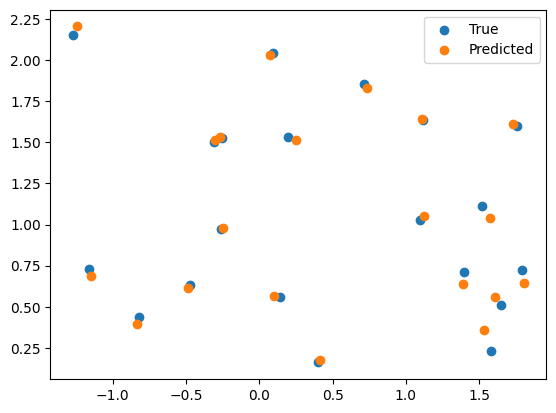

In [16]:
# Plot the results
plt.scatter(y_test[:20, 0], y_test[:20, 1], label='True')
plt.scatter(y_pred[:20, 0], y_pred[:20, 1], label='Predicted')
plt.legend()
plt.show()

***

### Προβλέψεις μέσω Νευρωνικού !!! (exciting!)

Έχουμε ``` input_size = 4000 ```

Και ```output_size = 2```

Θα φτιάξουμε ένα απλό γραμμικό μοντέλο για εξοικείωση

Το μοντέλο θα τρέξει στην GPU αν αυτή είναι διαθέσιμη.

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


Προετοιμάζουμε τα δεδομένα όπως και προηγουμένως με το XGB μοντέλο

In [18]:
# Reshape the tensor to 2D so that it can be used in the linear model
X = input_array.reshape(len(input_array), -1)
print(X.shape)

(5000, 4000)


In [19]:
y = labels
print(y.shape)

(5000, 2)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4000, 4000)
(1000, 4000)


Μετατρέπουμε όλα μας τα data σε torch tensors για να είναι συμβατά με την αρχιτεκτονική του μοντέλου και τα περνάμε στην συσκευή που χρησιμοποιούμε (CPU ή GPU).

In [21]:
# Transform the data to PyTorch tensors and move them to the GPU if available
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Δημιουργούμε ```mini_batches``` των 32.

In [22]:
from torch.utils.data import DataLoader, TensorDataset

# Define the dataset
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Define the data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

Το μοντέλο αρχικά αποτελείται από 3 επίπεδα, με συνάρτηση ενεργοποίησης ```LeakyReLU``` η οποία μας βοηθάει να αποφύγουμε να κολλήσουμε σε μία συγκεκριμένη τιμή κατά την διάρκεια του ```training``` με αποτέλεσμα να καταστραφεί το μοντέλο.

In [23]:
from torch import nn

# Build the model

class FirstModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(FirstModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [24]:
# Define the input and output sizes
input_len = X_train_scaled.shape[1]
output_len = y_train.shape[1]

# Instantiate the model
model_0 = FirstModel(input_size=input_len, output_size=output_len)
model_0.to(device)

FirstModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

Αρχικοποιούμε τα βάρη καθώς παρατηρήθηκε ότι η αρχική τυχαιότητα μπορεί να καταστρέψει τα αποτελέσματα.

In [25]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        m.bias.data.zero_()  # Important to avoid big initial outputs!

model_0.apply(init_weights)


FirstModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

Ορίζουμε την ```loss_function``` τον ```optimizer``` καθώς και τον ```learning_scheduler``` για να μειώσει τον ρυθμό εκμάθησης όσο πλησιάζουμε στην σύγκλιση.

Για ```optimizer``` δοκίμασα Adam, SGD και RMSprop, με παρόμοια αποτελέσματα.

In [26]:
# Define the loss function and the optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

Κάνουμε train το μοντέλο για 100 εποχές.

***SOS*** Για επαναληψιμότητα τρέχουμε όλα τα cells [59] - [72] με την **ΣΕΙΡΑ** αλλιώς ο optimizer αρχικοποιείται σε διαφορετικές παραμέτρους.

In [27]:
# Fit the model
torch.manual_seed(42)
epochs = 100
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    model_0.train()
    epoch_loss = 0

    # Iterate over mini-batches
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model_0(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        epoch_loss += loss.item()

    # Store average training loss
    train_loss_arr.append(epoch_loss / len(train_loader))

    scheduler.step(epoch_loss)
    after_lr = optimizer.param_groups[0]['lr']

    # Evaluate the model on a test set
    model_0.eval()
    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            y_test_pred = model_0(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()

    test_loss_arr.append(test_loss / len(test_loader))


    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
print(f'Epoch {epoch + 1} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')


Epoch 0 | Loss train: 84.11598738574982 | Loss test: 0.4945996357128024 | lr = 0.01
Epoch 10 | Loss train: 0.07731690007448197 | Loss test: 0.06989444035571069 | lr = 0.01
Epoch 20 | Loss train: 0.07649062206596136 | Loss test: 0.1397071247920394 | lr = 0.01
Epoch 30 | Loss train: 0.014420550275593996 | Loss test: 0.007631044078152627 | lr = 0.001
Epoch 40 | Loss train: 0.0018980907849036157 | Loss test: 0.002115987372235395 | lr = 0.001
Epoch 50 | Loss train: 0.001596408061683178 | Loss test: 0.0021238526824163273 | lr = 0.001
Epoch 60 | Loss train: 0.00192840058170259 | Loss test: 0.0013207077336119255 | lr = 0.001
Epoch 70 | Loss train: 0.0012708533317781984 | Loss test: 0.002170716608816292 | lr = 0.001
Epoch 80 | Loss train: 0.0002952465649577789 | Loss test: 0.00037876495389355114 | lr = 0.0001
Epoch 90 | Loss train: 0.00019311471364926548 | Loss test: 0.0002748336753484182 | lr = 0.0001
Epoch 100 | Loss train: 0.0001821573773631826 | Loss test: 0.00023522719129687175 | lr = 0.00

Τι ωραία νούμερα!!! Μακάρι να αντικατοπτρίζουν την πραγματικότητα.

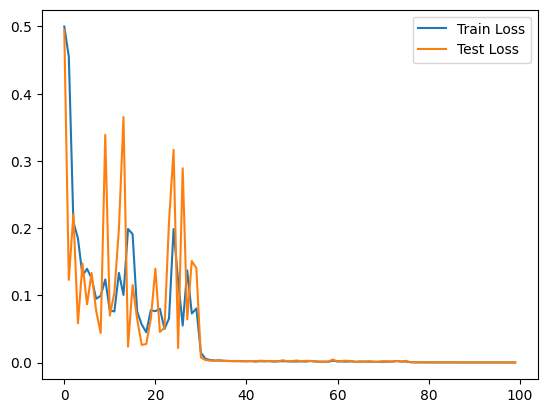

In [29]:
# Plot the loss
train_loss_arr[0] = 0.5 #Only for visualization reasons, since first training loss is a lot larger than the rest numbers
plt.plot(train_loss_arr, label='Train Loss')
plt.plot(test_loss_arr, label='Test Loss')
plt.legend()
plt.show()

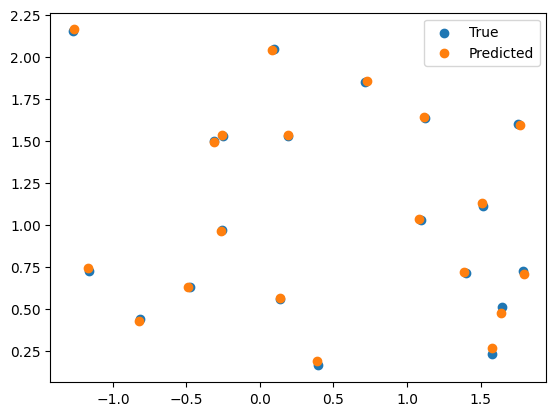

In [30]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0(X_test_tensor)

# Plot the results
plt.scatter(y_test[:20, 0], y_test[:20, 1], label='True')
plt.scatter(y_pred[:20, 0].cpu().detach().numpy(), y_pred[:20, 1].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.show()

**********************

### 1D CNN 

Καθώς τα δεδομένα μας προέρχονται σε μορφή 'χρονοσειράς' δηλαδή το ένα δείγμα έχει άμεση εξάρτηση από το προηγούμενό του κάνουμε την υπόθεση ότι μία αρχιτεκτονική όπως τα CNN (Convolutional Neural Network) θα δώσει καλύτερα αποτελέσματα αφού δεν αναγκαζόμαστε να ισοπεδώσουμε τον πίνακα των δεδομένων και αντ'αυτού διατηρούμε την σύνδεση των χρονικών στιγμών.

Πάλι θα χρησιμοποιήσουμε την GPU αν αυτή είναι διαθέσιμη

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


Τα δεδομένα βρίσκονται στον ```input_array``` διαστάσεων $(5000, 1000, 4)$ ενώ οι συντεταγμένες του RFID tag βρίσκονται στον πίνακα ```labels``` διαστάσεων $(5000, 2)$

In [32]:
X = input_array
X.shape

(5000, 1000, 4)

In [33]:
y = labels
y.shape

(5000, 2)

Χωρίζουμε τα δεδομένα μας σε train και test όπως και προηγουμένως και στην συνέχεια τα κανονικοποιούμε, ανάλογα με την μέση τιμή του κάθε χαρακτηριστικού και την διακύμανσή του.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Reshape to (4000*1000, 4) to compute mean/std for each feature
reshaped_tensor = X_train.reshape(-1, 4)

# Compute mean and std deviation for each feature
mean_vals = reshaped_tensor.mean(axis = 0)
std_vals = reshaped_tensor.std(axis = 0)

# Normalize each feature to zero mean and unit variance
X_train = (X_train - mean_vals) / std_vals
X_test = (X_test - mean_vals) / std_vals

# Handle division by zero (if std = 0) for any feature
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)


C:\Users\jimka\AppData\Local\Temp\ipykernel_4440\3003580875.py:9: RuntimeWarning: invalid value encountered in divide
  X_train = (X_train - mean_vals) / std_vals
C:\Users\jimka\AppData\Local\Temp\ipykernel_4440\3003580875.py:10: RuntimeWarning: invalid value encountered in divide
  X_test = (X_test - mean_vals) / std_vals


Τα τοποθετούμε στην συσκευή που θα χρησιμοποιήσουμε.

In [36]:
# Transform the data to PyTorch tensors and move them to the GPU if available
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [37]:
X_train_tensor.shape , X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([4000, 1000, 4]),
 torch.Size([1000, 1000, 4]),
 torch.Size([4000, 2]),
 torch.Size([1000, 2]))

Δημιουργούμε πάλι mini_batches των 32 για καλύτερη απόδοση.

In [38]:
from torch.utils.data import DataLoader, TensorDataset

# Define the dataset
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Define the data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

Δεν γνωρίζω κάποια στάνταρ αρχιτεκτονική οπότε το CNN για την ώρα δεν είναι φιλοσοφημένο.

In [39]:
import torch.nn as nn

class FirstCNN(nn.Module):
    def __init__(self, features, output_shape, hidden_units=128):
        super(FirstCNN, self).__init__()

        self.FirstConvBlock = nn.Sequential(
            nn.Conv1d(in_channels=features, out_channels=hidden_units, kernel_size=9, stride=1, padding='same'),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm1d(hidden_units), 
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        self.PoolingBlock = nn.MaxPool1d(kernel_size=2)

        # Dynamically calculate flattened size
        self.dummy_input = torch.randn(1, features, 1000)  # Simulate a single input sample
        with torch.no_grad():
            dummy_output = self.PoolingBlock(self.FirstConvBlock(self.dummy_input))
            self.flattened_size = dummy_output.view(-1).shape[0]

        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= self.flattened_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_shape),   
        )
    
    def forward(self, x):
        x = x.transpose(1, 2)  # Convert [batch_size, sequence_length, features] -> [batch_size, features, sequence_length]
        x = self.FirstConvBlock(x)
        x = self.PoolingBlock(x)
        x = self.linear_stack(x)
        return x


In [40]:
input_size = X_train_tensor.shape[2]
output_size = y_train.shape[1]

model_1 = FirstCNN(features= input_size, output_shape= output_size)
model_1.to(device)

FirstCNN(
  (FirstConvBlock): Sequential(
    (0): Conv1d(4, 128, kernel_size=(9,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.3, inplace=False)
  )
  (PoolingBlock): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64000, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [41]:
# Define the loss function and the optimizer
learning_rate = 1e-3


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

In [42]:
# Fit the model
torch.manual_seed(42)
epochs = 100
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    model_1.train()
    epoch_loss = 0

    # Iterate over mini-batches
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model_1(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        epoch_loss += loss.item()

    # Store average training loss
    train_loss_arr.append(epoch_loss / len(train_loader))

    scheduler.step(epoch_loss)
    after_lr = optimizer.param_groups[0]['lr']

    # Evaluate the model on a test set
    model_1.eval()
    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            y_test_pred = model_1(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()

    test_loss_arr.append(test_loss / len(test_loader))


    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
print(f'Epoch {epoch + 1} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')


Epoch 0 | Loss train: 9.563359322309495 | Loss test: 0.3623146712779999 | lr = 0.001
Epoch 10 | Loss train: 0.057750900737941264 | Loss test: 0.13075290038250387 | lr = 0.001
Epoch 20 | Loss train: 0.0363251925855875 | Loss test: 0.24432534165680408 | lr = 0.001
Epoch 30 | Loss train: 0.022148940529674293 | Loss test: 0.11092001898214221 | lr = 0.001
Epoch 40 | Loss train: 0.01916008139029145 | Loss test: 0.09413835941813886 | lr = 0.001
Epoch 50 | Loss train: 0.01474736190214753 | Loss test: 0.14498829701915383 | lr = 0.001
Epoch 60 | Loss train: 0.008261573428288102 | Loss test: 0.09458912932313979 | lr = 0.0001
Epoch 70 | Loss train: 0.007503347889520228 | Loss test: 0.09049695916473866 | lr = 0.0001
Epoch 80 | Loss train: 0.006531975910067558 | Loss test: 0.1042230052407831 | lr = 1e-05
Epoch 90 | Loss train: 0.00596637339470908 | Loss test: 0.11537915258668363 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.0070165615347214045 | Loss test: 0.10047101229429245 | lr = 1.0000

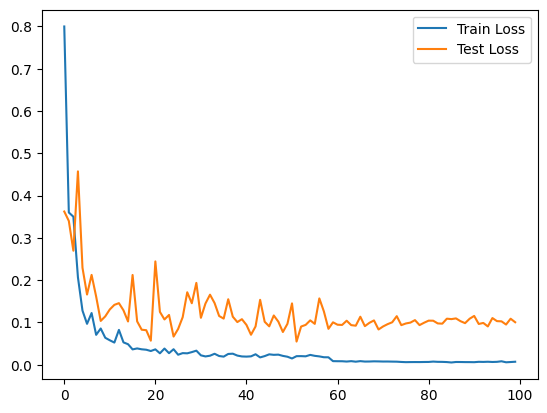

In [43]:
# Plot the loss
train_loss_arr[0] = 0.8 #Only for visualization reasons, since first training loss is a lot larger than the rest numbers
plt.plot(train_loss_arr, label='Train Loss')
plt.plot(test_loss_arr, label='Test Loss')
plt.legend()
plt.show()

Overfit